# Assignment 1.

### Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium

sns.set()
%matplotlib inline

# Part 1: Temporal Patterns

### Import & Edit Data

In [2]:
#Import the Data
data = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

#We look only at the focus-crimes in the exercise below
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT'])

#Select the Focus Crimes
focus_data = data.copy()
focus_data = focus_data[focus_data['Category'].isin(focuscrimes)]

#Exclude 2018 since we don't have full data for that year
focus_data = focus_data.drop(focus_data[focus_data['Date'].str.strip().str[-4:] == '2018'].index).reset_index(drop=True)

#Convert Date to Datetime
focus_data['Date'] = pd.to_datetime(focus_data['Date'], format='%m/%d/%Y')

### Weekly patterns. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. Hint for comment: Some things make sense - for example `drunkenness` and the weekend. But there are some aspects that were surprising to me. Check out `prostitution` and mid-week behavior, for example!?

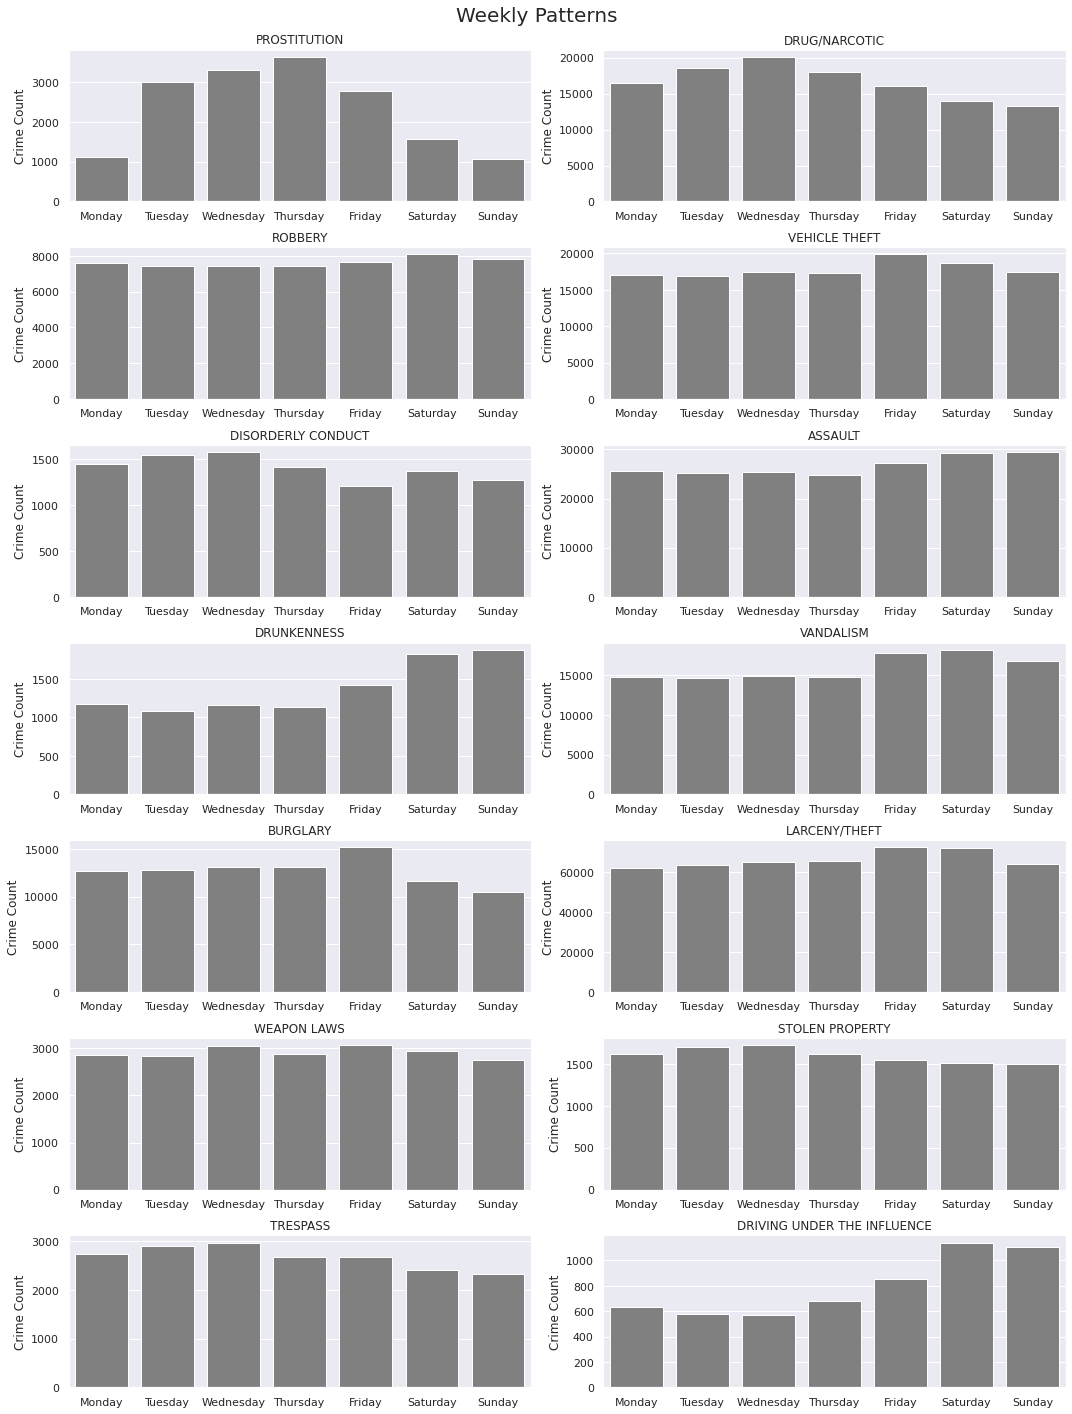

In [3]:
#Generate pivot table where each row represents the crimes and each column represents a different day.
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot1 = pd.pivot_table(focus_data, index = "Category", columns = "DayOfWeek", values = 'IncidntNum', aggfunc = 'count')
pivot1 = pivot1[days]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,20), sharex=False)
fig.suptitle("Weekly Patterns", fontsize=20)
col = ['DayOfWeek', 'Crime Count']

for i, crime in enumerate(focuscrimes):
    crime_data = pivot1.loc[crime]
    crime_dataframe = pd.DataFrame(crime_data.reset_index())
    crime_dataframe.columns = col
    sns.barplot(x='DayOfWeek', y='Crime Count', data=crime_dataframe, ax=axes[i//2,i%2], color='grey')
    axes[i//2,i%2].set_title(crime)
    axes[i//2,i%2].set(xlabel=None)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### <span style="color:red">Comment: </span> 
In most of the bar plots, every crime in each day doesn't differ so much. The only exceptions being `Drunkeness`, `Driving under the influence` and `Vandalism` which seems normal as vandalism correlates with drunkeness and as people may have free time during the weekend these crimes will have more cases. The most bizzare fact is that during the weekdays, prostitution counts many more crimes that counts during the weekends with a peak on **Thursday**.

---

### The months. We can also check if some months are worse by counting up number of crimes in Jan, Feb, ..., Dec. Did you see any surprises there?

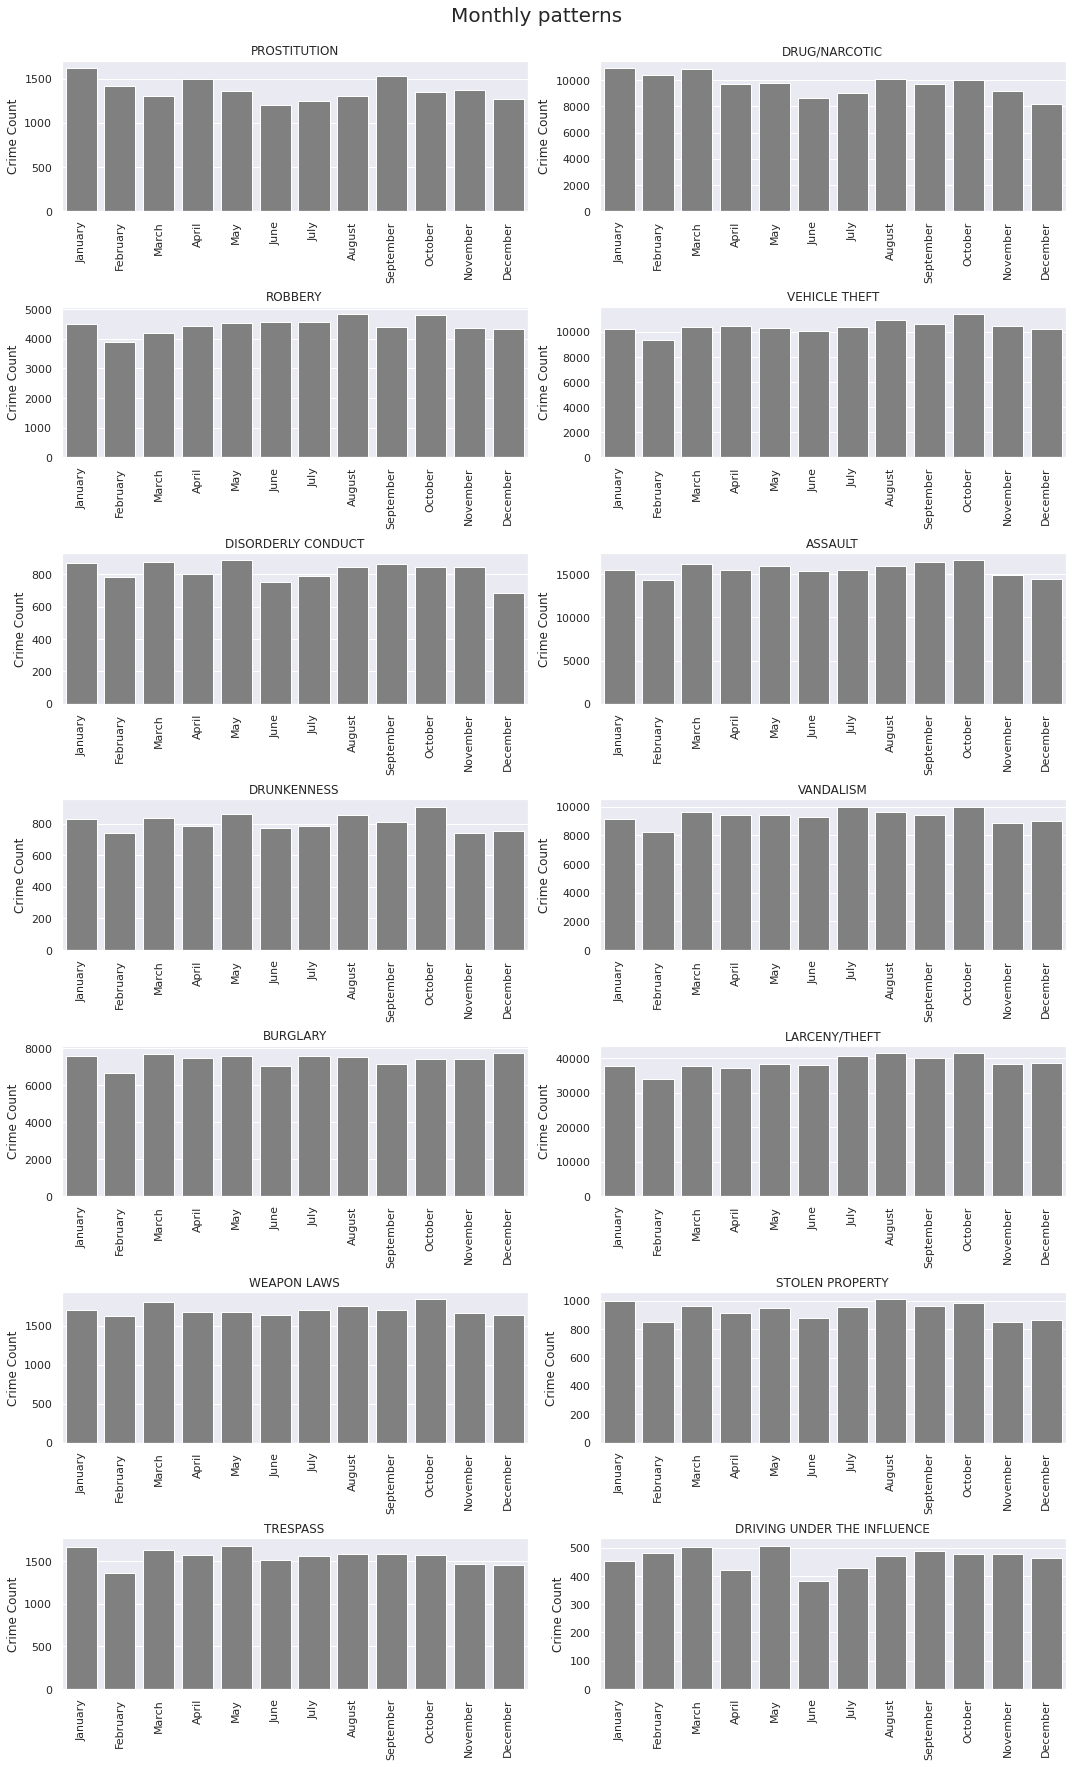

In [4]:
#Generate pivot table where each row represents the crimes and each column represents a different month.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pivot2 = pd.pivot_table(focus_data, index = "Category", columns = focus_data['Date'].dt.strftime('%B'),values = 'IncidntNum' ,aggfunc = 'count')
pivot2 = pivot2[months]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,25), sharex=False)
fig.suptitle("Monthly patterns", fontsize=20)
col = ['Months', 'Crime Count']

#Compute the average of each crime during each month


for i, crime in enumerate(focuscrimes):
    crime_data = pivot2.loc[crime]
    crime_dataframe = pd.DataFrame(crime_data.reset_index())
    crime_dataframe.columns = col
    sns.barplot(x='Months', y='Crime Count', data=crime_dataframe, ax=axes[i//2,i%2], color='grey')
    axes[i//2,i%2].set_title(crime)
    axes[i//2,i%2].set(xlabel=None)
    axes[i//2,i%2].set_xticklabels(axes[i//2,i%2].get_xticklabels(), rotation=90)
    #axes[i//2,i%2].axhline([crime], color='r', linestyle='-', label='Average')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### <span style="color:red">Comment: </span> 
Here due to the fact that the differences were quite indistinguishable a horizontal line was added to the plots which represents the average number of each crime. As a conclusion, there aren't many surpises here as everything seems moving slightly on both sides of the average. The only pattern that is easily observed is that in **June** some crimes may have much less arrests and it is reasonable to ask if it due to police work or in fact to crimes not being commited.

---

### The 24 hour cycle*. We'll can also forget about weekday and simply count up the number of each crime-type that occurs in the entire dataset from midnight to 1am, 1am - 2am ... and so on. Again: Give me a couple of comments on what you see.

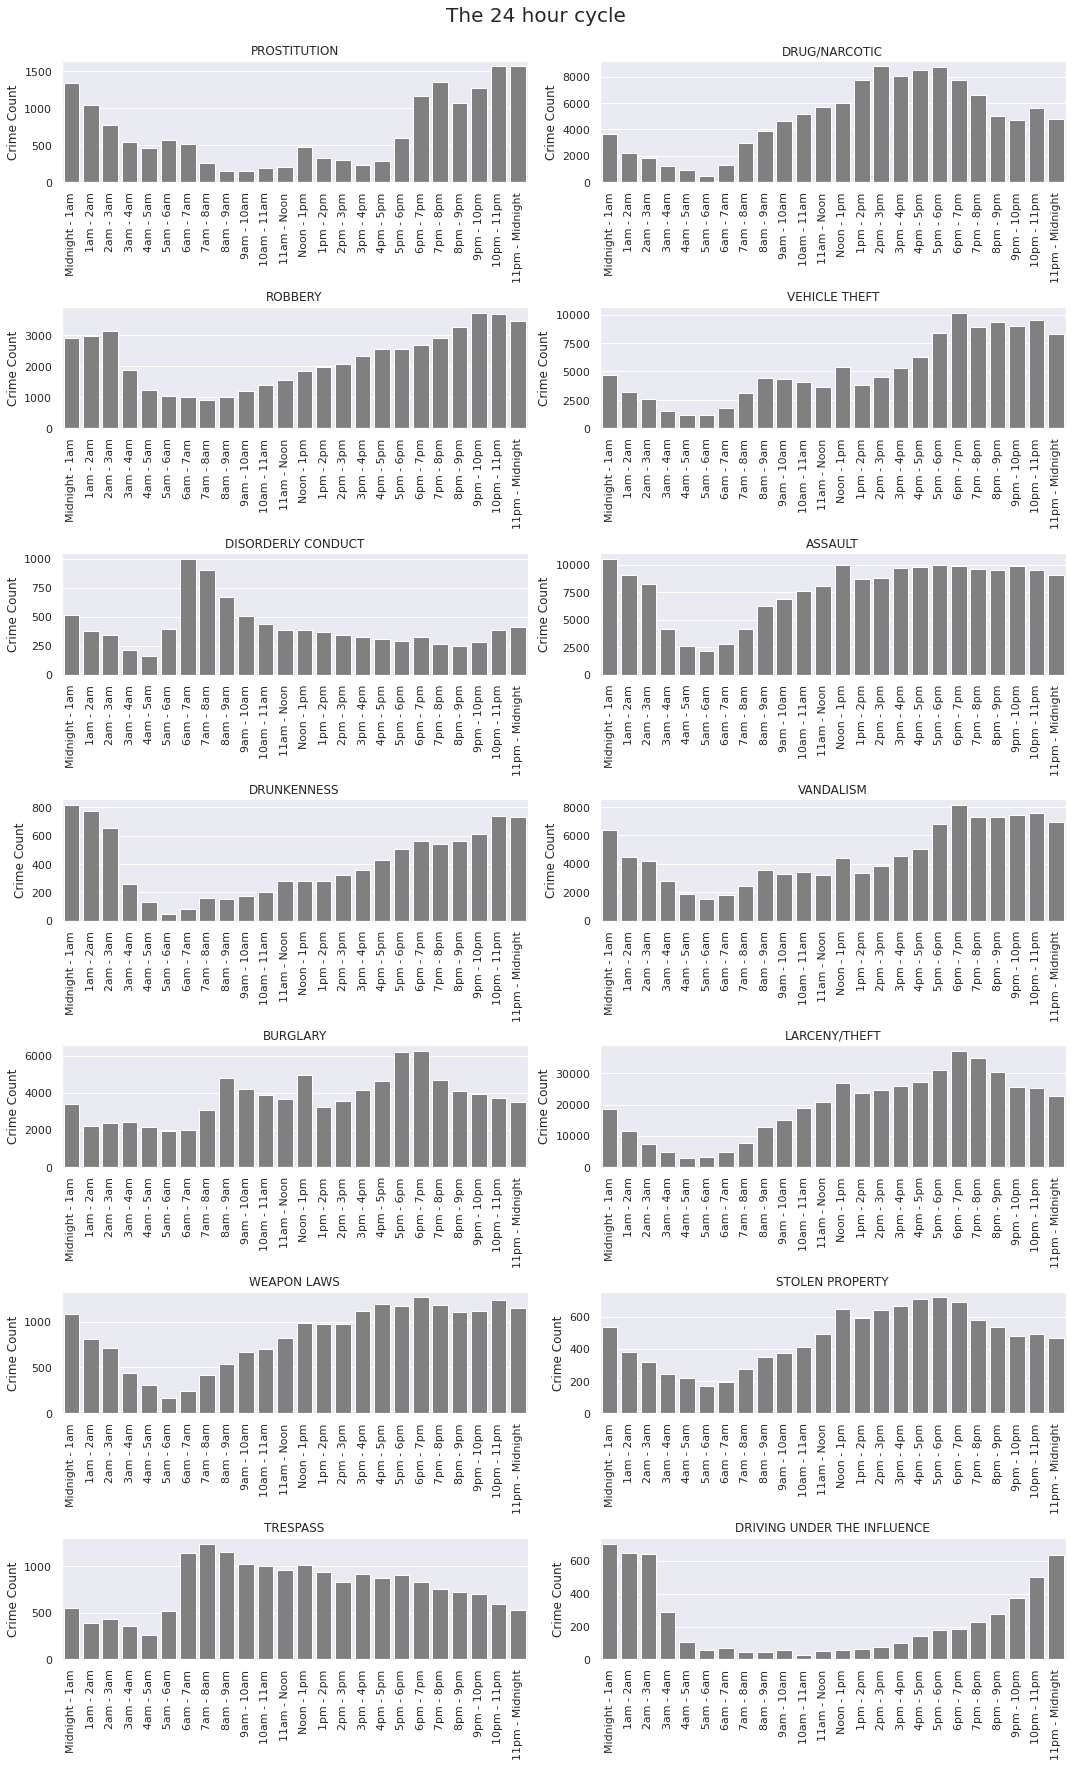

In [5]:
#Generate a pivot table for the 24 hour cycle
focus_data['Hour'] = focus_data['Time'].str.strip().str[0:2]

hours = ['Midnight - 1am', '1am - 2am', '2am - 3am', '3am - 4am', '4am - 5am', '5am - 6am', '6am - 7am', '7am - 8am', '8am - 9am', '9am - 10am', '10am - 11am', '11am - Noon', 'Noon - 1pm', '1pm - 2pm', '2pm - 3pm', '3pm - 4pm', '4pm - 5pm', '5pm - 6pm', '6pm - 7pm', '7pm - 8pm', '8pm - 9pm', '9pm - 10pm', '10pm - 11pm', '11pm - Midnight']
temp_hour = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

for i in range(9):
    focus_data['Hour'] = focus_data['Hour'].str.replace(temp_hour[i], hours[i])    
focus_data['Hour'] = focus_data['Hour'].str.replace('09', '%temp1%').replace('10', '%temp2%').replace('11', '11am - Noon').replace('%temp2%', '10am - 11am').replace('%temp1%', '9am - 10am')
for i in range(12):
    focus_data['Hour'] = focus_data['Hour'].str.replace(temp_hour[i+12], hours[i+12])
    
pivot3 = pd.pivot_table(focus_data, index = "Category", columns = "Hour",values = 'IncidntNum' ,aggfunc = 'count')
pivot3 = pivot3[hours]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,25), sharex=False)
fig.suptitle("The 24 hour cycle", fontsize=20)
col = ['Hours', 'Crime Count']

for i, crime in enumerate(focuscrimes):
    crime_data = pivot3.loc[crime]
    crime_dataframe = pd.DataFrame(crime_data.reset_index())
    crime_dataframe.columns = col
    sns.barplot(x='Hours', y='Crime Count', data=crime_dataframe, ax=axes[i//2,i%2], color='grey')
    axes[i//2,i%2].set_title(crime)
    axes[i//2,i%2].set(xlabel=None)
    axes[i//2,i%2].set_xticklabels(axes[i//2,i%2].get_xticklabels(), rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### <span style="color:red">Comment: </span> 
These plots are very interesting due to the fact that can be studied and create patterns behind each crime. As it is normal, the crime rates for some crimes are high during the day and for some others during the night. `'BURGLARY'` crime rates are interesting as someone could imagine that most burglaries will happen during the night, but this isn't the case. The plot show that most burglaries happen during the day, maybe when people are on work. Also trespassing seems interesting as it utterly increases at 6am. One expectable pattern is the high correlation that can be observed at `'DRUNKNESS'` and `'DRIVING UNDER THE INFLUENCE'`. In addition, at the `'DISORDERLY CONDUCT'` there is a peak during 6 am – 7 am. This is the time interval that more people are on the road for their job and as a social phenomenon can be connected with the traffic and the stress which is generated to the people from the fast paced environment. 

---

### Hours of the week. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight.

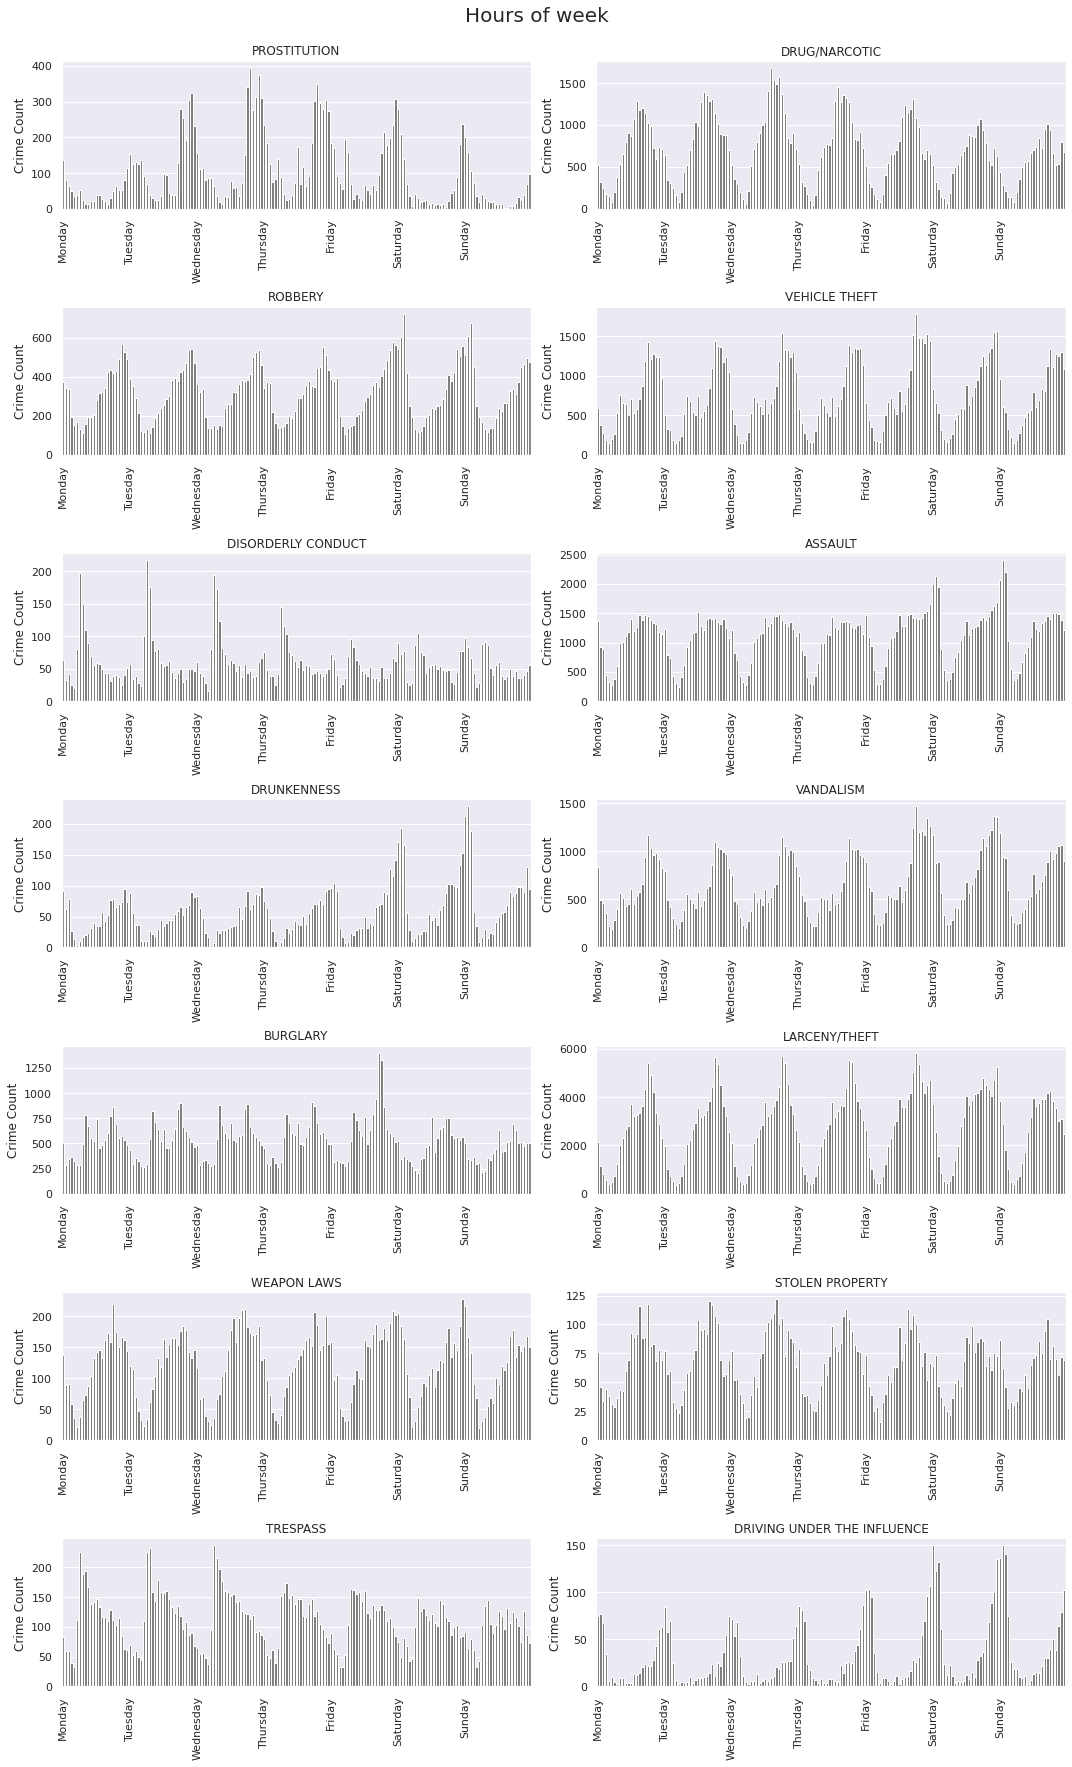

In [6]:
focus_data['int_hour'] = pd.to_datetime(focus_data['Time'], format = '%H:%M').dt.hour
focus_data['int_day'] = focus_data['DayOfWeek'].str.replace('Monday', '0').replace('Tuesday', '24').replace('Wednesday', '48').str.replace('Thursday', '72').str.replace('Friday', '96').str.replace('Saturday', '120').str.replace('Sunday', '144')
focus_data['int_day'] = focus_data['int_day'].astype(int)
focus_data['Weekhour'] = focus_data['int_hour'] + focus_data['int_day']

weekhours = list(range(168))
pivot4 = pd.pivot_table(focus_data, index = "Category", columns = "Weekhour", values = 'IncidntNum' ,aggfunc = 'count')
pivot4 = pivot4[weekhours]

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,25), sharex=False)
col = ['Weekhour', 'Crime Count']
fig.suptitle("Hours of week", fontsize=20)

for i, crime in enumerate(focuscrimes):
    crime_data = pivot4.loc[crime]
    crime_dataframe = pd.DataFrame(crime_data.reset_index())
    crime_dataframe.columns = col
    sns.barplot(x='Weekhour', y='Crime Count', data=crime_dataframe, ax=axes[i//2,i%2], color='grey')
    axes[i//2,i%2].set_title(crime)
    axes[i//2,i%2].set(xlabel=None)
    axes[i//2,i%2].set_xticks([0, 24, 48, 72, 96, 120, 144])
    axes[i//2,i%2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=90)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### <span style="color:red">Comment: </span> 
In these plots many more trends are easily observed. We could easily say that the above plots are a combination of the 1st - 3rd set of plots and provide us a more clear overview than the hourly-weekly patterns. This hourly-daily combination shows what to expect during every moment. Many crimes have balanced crime rates, but others show an abnormal behaviour during a specific small period of the week. In some cases we can see that the shape of the plot seems like the plot of a periodic function. On the other hand, in some other cases like `'PROSTITUTION'`, `'DISORDERLY CONDUCT'` `'PROSTITUTION'` or `'DRUNKENNESS'` we can see that described phenomenon is on the rise specific days and specific hours of the week.

---

# Part 2: Thinking about data and visualization

### As mentioned earlier, visualization is not the only way to test for correlation. We can (for example) calculate the Pearson correlation. Explain in your own words how the Pearson correlation works and write down it's mathematical formulation. Can you think of an example where it fails (and visualization works)?

### <span style="color:red">Answer: </span>
Pearson correlation describes the relationship between two attributes. It quantifies the strength of the relationship. It can take values from -1 to 1. If the correlation is 1, then both the attributes increase with the same rate.

$$p_{X,Y} = \frac{cov(X,Y)}{σ_{Χ}σ_{Υ}}$$

The best example that shows the Pearson correlation isn't always the best method and visualization is much more helpful is the Anscombe's quarter which is a collection of 4 datasets that have almost identical simple descriptive statistics but as we can see from the image below the relationship among the data is not similar.
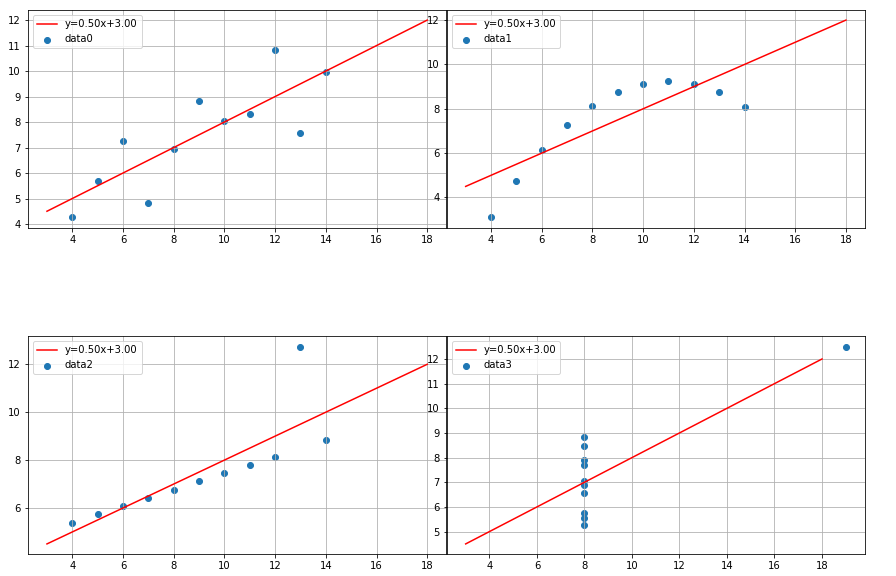

---

### What is the difference between a bar-chart and a histogram?

### <span style="color:red">Answer: </span>
We use bar charts for categorical variables and histograms for numerical ones. In addition, we mainly use histograms when we want to identify the the distribution of a variable.

---

### I mention in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 

### <span style="color:red">Answer: </span>
A very popular and effective method to approach an appropriate width of the bins in order to not loose information from our histogram is the well known Freedman–Diaconis rule. According to this rule we can find the width of the bins using the following formula:
$$ Bin \: width = 2\frac{IQR(x)}{\sqrt[3]{n}} $$
Where:
* $IQR(x)\:$  is the Interquartile range : $IQR(x) = Q_3-Q_1$
* $n$ is the number of observations in the sample $x$
If we want to find the appropriate number of bins we can then use the formula:
$$Number\: of \:bins = \frac{Range}{Bin \: width} $$ and finally round the result.

# Part 3: Generating important plot types

Let us recreate some plots from DAOST but using our own favorite dataset.

### First, let's make a jitter-plot (that is, code up something like **Figure 2-1** from DAOST from scratch), but based on SF Police data. My hunch from inspecting the file is that the police-folks might be a little bit lazy in noting down the **exact** time down to the second. So choose a crime-type and a suitable time interval (somewhere between a month and 6 months depending on the crime-type) and create a jitter plot of the arrest times during a single hour (like 13-14, for example). So let time run on the $x$-axis and create vertical jitter.

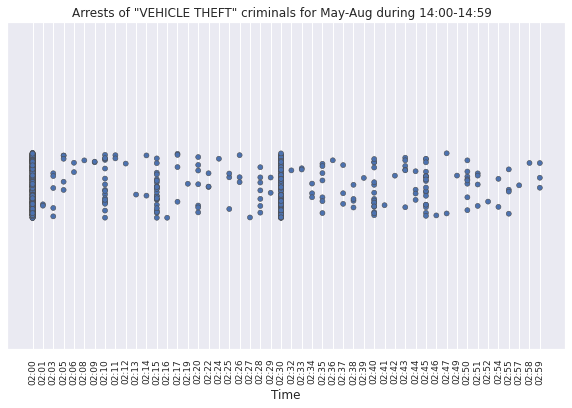

In [7]:
hour_data = data[['Category', 'Date', 'Time']]
hour_data = hour_data[hour_data['Category'] == 'VEHICLE THEFT']
hour_data = hour_data[hour_data['Date'].str[:2].isin(['05','06','07','08'])]
hour_data = hour_data[hour_data['Time'].str[:2] == '02']
hour_data.sort_values('Time', inplace=True)
hour_data = hour_data.reset_index(drop = True)
hour_data['Minutes'] = hour_data['Time'].str[3:].astype(int)

fig, axes = plt.subplots(figsize=(10,6))

sns.stripplot(x="Time", data=hour_data, linewidth=0.55, dodge=True, marker="o", ax=axes)

plt.xticks(rotation = 90, fontsize = 9)
plt.title('Arrests of "VEHICLE THEFT" criminals for May-Aug during 14:00-14:59  ')
plt.show()

### <span style="color:red">Comment: </span>
Thirty minutes past the hour, crimes don't appear to be recorded. It is normal to select increments of 5, 10 or 15 minutes but the crime arrests half past the hour don't appear to follow that distribution.

---

## Now for some histograms (please create a crime-data based versions of the plot-type shown in DAOST **Figure 2-2**). (I think the GPS data could be fun to understand from this perspective.) 

### This time, pick two crime-types with different geographical patterns **and** a suitable time-interval for each (you want between 1000 and 10000 points in your histogram)

In [8]:
geo_data = data[['Category', 'Date', 'X', 'Y']].copy()
geo_data = geo_data[geo_data['Date'].str.strip().str[-4:].astype(int) < 2010]
crime1 = geo_data[geo_data['Category'] == 'DISORDERLY CONDUCT']
crime2 = geo_data[geo_data['Category'] == 'WEAPON LAWS']
crime1 = crime1[crime1['Y'] < 40]
crime2 = crime2[crime2['Y'] < 40]
crime1 = crime1.reset_index(drop = True)
crime2 = crime2.reset_index(drop = True)

### Then take the latitude part of the GPS coordinates for each crime and bin the latitudes so that you have around 50 bins across the city of SF. You can use your favorite method for binning. I like `numpy.histogram`. This function gives you the counts and then you do your own plotting. 

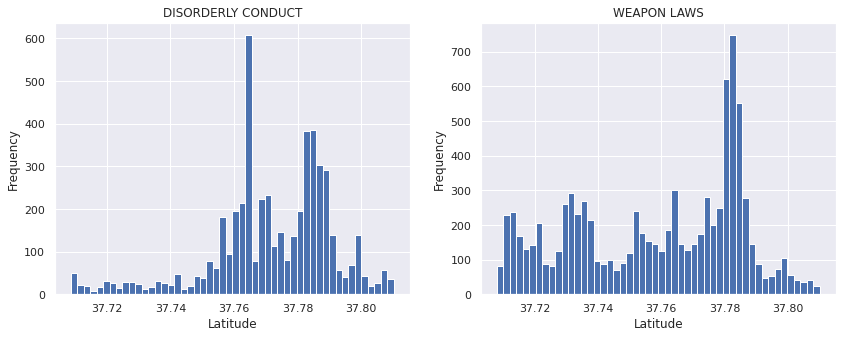

In [9]:
crime_lat = [crime1, crime2]
cat_name = ['DISORDERLY CONDUCT', 'WEAPON LAWS']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

for i,temp in enumerate(crime_lat):
    axes[i].hist(temp['Y'], bins=50)
    axes[i].set_title(cat_name[i])
    axes[i].set_xlabel('Latitude')
    axes[i].set_ylabel('Frequency')

### <span style="color:red">Comment: </span>
The latitude for two different crimes. Both of the crimes seem to have a latitude that the rates are increased, with weapon laws to being balanced, to other values.

# Part 4: A bit of geo-data

Now we look at studying geospatial data by plotting raw data points as well as heatmaps on top of actual maps.

### First start by plotting a map of San Francisco with a nice tight zoom. Simply use the command folium.Map([lat, lon], zoom_start=13), where you'll have to look up San Francisco's longitude and latitude.

In [10]:
lat = 37.773972
lon = -122.431297

sf = folium.Map([lat, lon], tiles='Stamen Terrain', zoom_start=13)

display(sf)

### Next, use the the coordinates for SF City Hall 37.77919, -122.41914 to indicate its location on the map with a nice, pop-up enabled maker.

In [11]:
ch_lat = 37.77919
ch_lon = -122.41914

folium.Marker([ch_lat, ch_lon], popup='SF City Hall').add_to(sf)
display(sf)

### Now, let's plot some more data (no need for popups this time). Select a couple of months of data for 'DRUG/NARCOTIC' and draw a little dot for each arrest for those two months. You could, for example, choose June-July 2016, but you can choose anything you like - the main concern is to not have too many points as this uses a lot of memory and makes Folium behave non-optimally. We can call this a kind of visualization a *point scatter plot*.

In [12]:
drug_data = data[data['Category'].isin(['DRUG/NARCOTIC'])].reset_index(drop=True)
drug_data['M/Y'] = drug_data['Date'].str.strip().str[:3] + drug_data['Date'].str.strip().str[-4:]
drug_data = drug_data[drug_data['M/Y'].isin(['06/2016','07/2016'])].reset_index(drop=True)

sf1 = folium.Map([lat, lon], tiles='Stamen Terrain', zoom_start=13)
folium.Marker([ch_lat, ch_lon], popup='London Bridge').add_to(sf1)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Arrest location for drug/narcotics during june-july 2016</b></h3>
             '''
sf1.get_root().html.add_child(folium.Element(title_html))

for i in range(len(drug_data)):
    folium.CircleMarker(location=[drug_data['Y'][i], drug_data['X'][i]], radius=2, weight=2, color='red').add_to(sf1)


display(sf1)

# Part 5: Errors in the data. The importance of looking at raw (or close to raw) data.



We started the course by plotting simple histogram plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. 

1. In the hourly activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2021/master/files/prostitution_hourly.png), where I've highlighted the phenomenon I'm talking about.
1. When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2021/master/files/jitter_plot.png), where I've highlighted the phenomenon I'm talking about.
1. And finally, today we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2021/master/files/crime_hot_spot.png).

### For each of the three examples above, describe in your own words how the data-errors I call attention to above can bias the binned versions of the data. Also briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).

### <span style="color:red">Answer: </span>
When data are being recorded by humans many biased information may be gathered. These information include the highly increase in prostitution during wednesday and thurday which may be due to that kind of paperwork to be dealed in that days. Surely, it is an abnormal pattern that requires further investigation. Another abnormal pattern are the recorded crimes on the hour, as it was mentioned above it is normal for the data to be gather in increments of 5, 10 and 15 minutes, but not normal to stop half past the hour. It is sure a biased error, and needs to be handled with caution. Lastly, in some specific coordinates the crime rate for sex offences was very increased, a pattern could be created for that spot. With further investigation, the conclusion was made that due to being a police station, many crimes can be registered there creating a false impression.

In each case, the correlation between the values could change and could be biased by these human activities. These information should either be excluded, in order not to create false patterns.